In [1]:
import meshio
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
from xrd_simulator_addons import get_ground_truth_slice
import multiprocessing as mp
import yaml
import h5py
import re
import os
import glob
from tqdm import tqdm
import utils.polar as polar
from functools import partial
import cupy as cp

In [2]:


config_path = 'xrd_simulator_addons/configs/config_crystal_exp4.yaml'
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
absolute_path = config["absolute_path"]
session_name = config["session_name"]
N_angles = config["experiment"]["number_of_angles"]
angles = np.linspace(0,180, N_angles)
N_translations = config["experiment"]["number_of_translations"]
integrated_path = absolute_path +'/' +session_name + '/integrated.h5'

/dtu-compute/msaca/simulated_data/diffraction/reference_183960_FeCr2O4_chro/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_180326_Na(AlSi3O8)_alb/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_184824_Ca5(PO4)3Cl_chl/integrated.h5


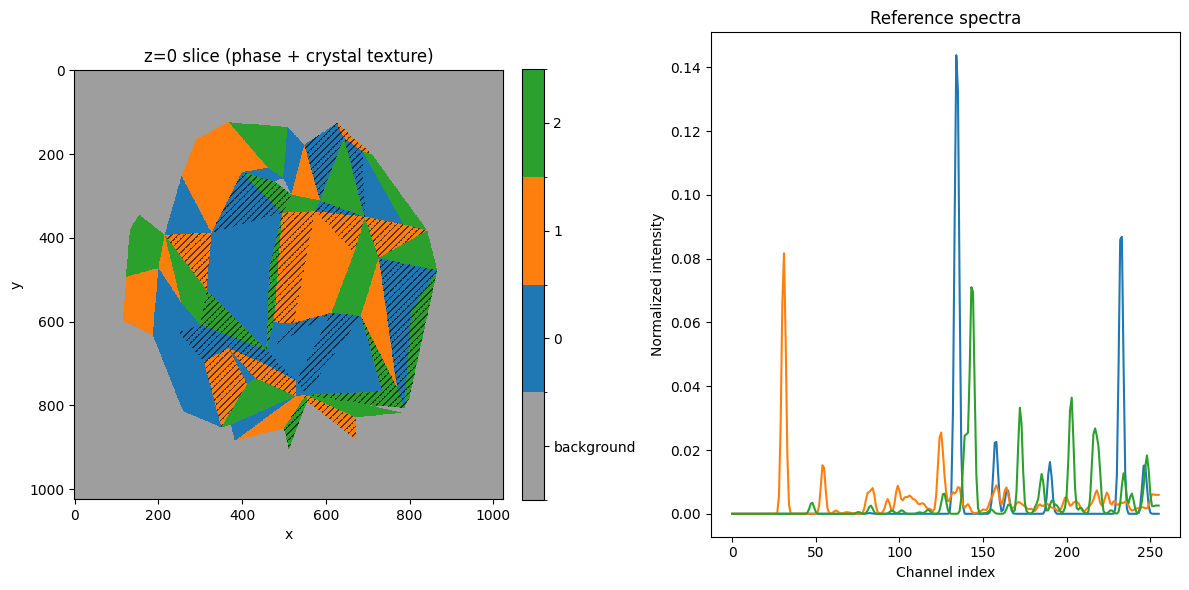

In [3]:
# --- Your data loading ---
phase_map, crystal_map = get_ground_truth_slice.get_ground_truth(config=config_path)

materials = config["materials"]["files"]
spec = []
for i in range(len(materials)):
    reference_path = absolute_path + '/reference_' + materials[i][:-4] + '/integrated.h5'
    print(reference_path)
    with h5py.File(reference_path, "r") as f:
        s = f["integrated_p"][:][0, 1, :]
        spec.append(s / s.sum())

# --- Colormaps ---
cmap = ListedColormap([
    "#9e9e9e",  # background
    "#1f77b4",  # class 0
    "#ff7f0e",  # class 1
    "#2ca02c",  # class 2
])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

new_cmaps = []
for i, color in enumerate(cmap.colors):
    new_cmaps.append(
        LinearSegmentedColormap.from_list(f"class_{i}", ["white", color])
    )

# --- Create one figure with two panels ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: phase + crystal texture ---
im = ax1.imshow(phase_map, origin='lower', interpolation='nearest',
                cmap=cmap, norm=norm)

ny, nx = crystal_map.shape
xx, yy = np.meshgrid(np.arange(nx), np.arange(ny))
stripe = ((xx + 1*yy) % 16) < 4
mask = (crystal_map != 0)

alpha = (mask & stripe).astype(float) * 0.65
overlay = np.zeros((ny, nx, 4), dtype=float)
overlay[..., 3] = alpha

ax1.imshow(overlay, interpolation='nearest')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('z=0 slice (phase + crystal texture)')

cbar = plt.colorbar(im, ax=ax1, ticks=[-1, 0, 1, 2], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['background', '0', '1', '2'])

# --- Right: spectra ---
for i in range(len(spec)):
    ax2.plot(spec[i])
ax2.set_title("Reference spectra")
ax2.set_xlabel("Channel index")
ax2.set_ylabel("Normalized intensity")

plt.tight_layout()
plt.show()

In [ ]:
def extract_index(filename):
    match = re.search(r'angle_(\d+)\.h5', filename)
    return int(match.group(1)) if match else -1

# Load and stack patterns from one file
def load_one_file(filename):
    with h5py.File(filename, 'r') as f:
        patterns = [f[key][:] for key in sorted(f.keys())]
        return np.stack(patterns)  # shape: (num_j, H, W)
    

session_name = config["session_name"]
absolute_infolder = config["absolute_path"]
inpath = os.path.join(absolute_infolder, f"{session_name}")
files = sorted(glob.glob(inpath + "/angle_*.h5"), key=extract_index)
with mp.Pool(processes=16) as pool:
    all_patterns = list(
        tqdm(pool.imap(load_one_file, files), total=len(files))
    )
diffraction_4d = np.stack(all_patterns)  # (num_angles, num_j, H, W)
num_angles, num_j, H, W = diffraction_4d.shape

  0%|                                                                                                                                                                                                                                                   | 0/181 [00:00<?, ?it/s]

In [5]:


pol, max_rad = polar.cartesian_to_polar(diffraction_4d[0,100,:,:], num_phi=360,factor = 3)
detector_distance = config["experiment"]["detector_distance"]
pixel_size = config["experiment"]["pixel_size"]
r_max = pixel_size*max_rad
two_theta = np.linspace(0, 14, 200)
pol_reb = polar.detector_radius_to_twotheta(
    det_array=pol,
    two_theta_new=two_theta,  # degrees
    detector_distance=detector_distance,   # mm
    r_max=r_max                # mm
)


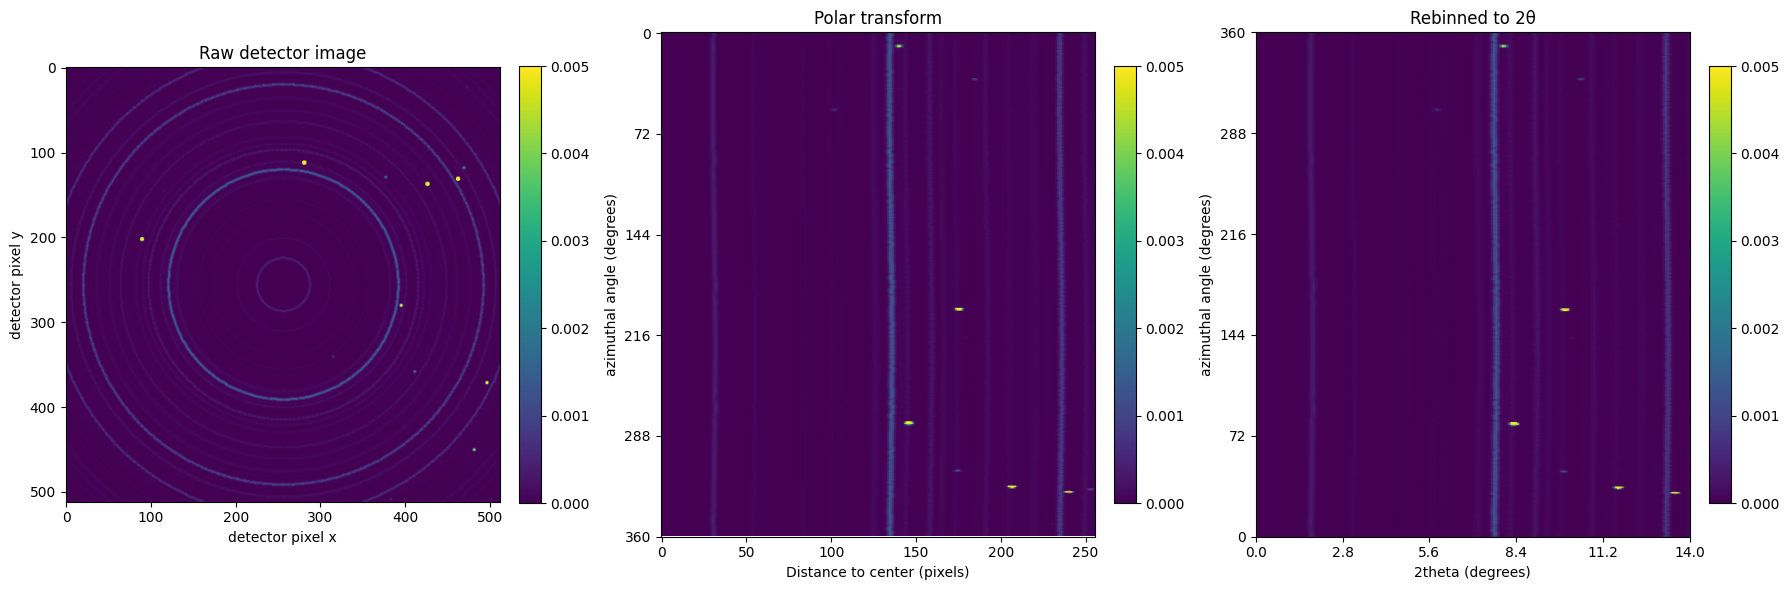

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# --- First plot: detector image ---
im1 = ax1.imshow(diffraction_4d[0, 100, :, :])
im1.set_clim([0, 0.005])
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel("detector pixel x")
ax1.set_ylabel("detector pixel y")
ax1.set_title("Raw detector image")

# --- Second plot: polar transform (r, azimuth) ---
im2 = ax2.imshow(pol, aspect='auto')
im2.set_clim([0, 0.005])
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel("Distance to center (pixels)")
ax2.set_ylabel("azimuthal angle (degrees)")
y_min, y_max = 0, 360
ax2.set_yticks(np.linspace(y_min, y_max, 6))
ax2.set_title("Polar transform")

# --- Third plot: polar re-binned to 2theta ---
x_min, x_max = two_theta[0], two_theta[-1]
y_min, y_max = 0, 360
im3 = ax3.imshow(pol_reb, aspect="auto",
                 extent=[x_min, x_max, y_min, y_max])
im3.set_clim([0, 0.005])
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_xlabel("2theta (degrees)")
ax3.set_ylabel("azimuthal angle (degrees)")
ax3.set_xticks(np.linspace(x_min, x_max, 6))
ax3.set_yticks(np.linspace(y_min, y_max, 6))
ax3.set_title("Rebinned to 2θ")

plt.tight_layout()
plt.show()



In [ ]:
diffraction_4d_gpu = cp.asarray(diffraction_4d)
two_theta = np.linspace(0, 14, 200)
out = polar.process_diffraction_cupy(
    diffraction_4d_gpu,
    num_phi=360,
    factor=3,
    two_theta_new=two_theta,
    detector_distance=detector_distance,
    r_max=r_max,
    chunk_size=64  # tune depending on GPU memory
)


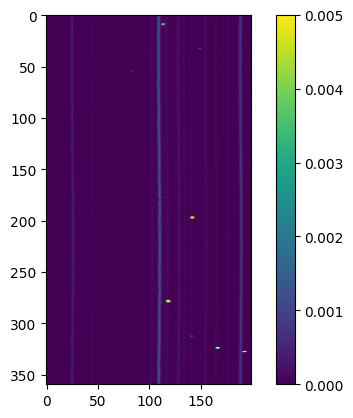

In [11]:
plt.imshow(out[0,100].get())
plt.colorbar()
plt.clim([0,0.005])